# Exemple de réseau de neurones récurrent avec Keras

Dans ce Notebook, nous utilisons les réseaux de neurones récurrents pour faire de l'analyse de sentiments avec Keras.

Nous utiliserons une couche du type GRU.

Nous travaillons sur les données IMDB de reviews sur des films.

#### Chargement des packages

In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import GRU # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### Choix des hyper-paramètres

In [3]:
# répertoire de sortie
output_dir = 'model_output/gru'

# apprentissage
epochs = 4
batch_size = 128

# base de la couche d'embbeding 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# Couche GRU
n_gru = 256 
drop_gru = 0.2

#### Chargement des données

In [21]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [51]:
# décodage d'une review
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in x_train[1] ))

funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then


#### Prétraitement des données

In [26]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Construction du réseau

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(GRU(n_gru, dropout=drop_gru))

model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               246528    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 886,785
Trainable params: 886,785
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Apprentissage

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 121s 5ms/step - loss: 0.5118 - acc: 0.7357 - val_loss: 0.3819 - val_acc: 0.8339
Epoch 2/4
25000/25000 [==============================] - 126s 5ms/step - loss: 0.3079 - acc: 0.8702 - val_loss: 0.3603 - val_acc: 0.8428
Epoch 3/4
25000/25000 [==============================] - 117s 5ms/step - loss: 0.2442 - acc: 0.9027 - val_loss: 0.3584 - val_acc: 0.8423
Epoch 4/4
25000/25000 [==============================] - 125s 5ms/step - loss: 0.2053 - acc: 0.9201 - val_loss: 0.3684 - val_acc: 0.8408


#### Evaluation du modèle

In [12]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [13]:
# on stocke les probabilités pour calculer l'AUC
y_hat = model.predict_proba(x_valid)

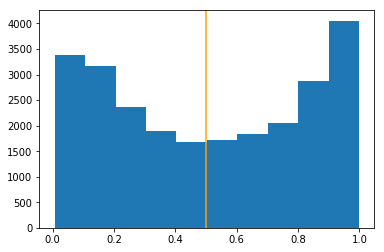

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'91.50'

#### Automatisation du traitement

En définissant une nouvelle review, on peut appliquer le modèle.

In [64]:
from nltk import word_tokenize
from keras.preprocessing import sequence
word2index = imdb.get_word_index()
test=[]
for word in word_tokenize( "what a nice movie"):
     test.append(word2index[word])

test=sequence.pad_sequences([test], maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
model.predict_proba(test)

array([[0.8831579]], dtype=float32)